In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
data = pd.read_csv('ARP_Dataset.csv')

for i in range(len(data)):
    if(data['pkt_rate'][i] < 0):
        data.drop(i,axis = 0,inplace = True)

data = data.dropna()
np.count_nonzero(data['Label'])

count = 0
random = np.random.randint(0,len(data),(50000))
for i in random:
    
    if(count == 10000):
        break
    try:
        index = data['Label'][i]
    except:
        continue
    else:   
        if(data['Label'][i] == 0):
            data.drop(i,axis = 0,inplace = True)
            count += 1

In [3]:
np.count_nonzero(data['Label'])

data['switch_id'] = data['switch_id'].astype(str) 
data['src_mac_addr(arp)'] = data['src_mac_addr(arp)'].astype(str)
data['dst_mac_addr(arp)'] = data['dst_mac_addr(arp)'].astype(str)
data['Protocol'] = data['Protocol'].astype(str)
data['src_mac_addr(eth)'] = data['src_mac_addr(eth)'].astype(str) 
data['dst_mac_addr(eth)'] = data['dst_mac_addr(eth)'].astype(str)
data['op_code(arp)'] = data['op_code(arp)'].astype(str) 
data['in_port'] = data['in_port'].astype(str) 
data['outport'] = data['outport'].astype(str) 

ordered_data = pd.get_dummies(data,
                              columns = ['switch_id', 'in_port', 'outport', 'src_mac_addr(eth)','src_mac_addr(arp)', 'dst_mac_addr(eth)', 'dst_mac_addr(arp)','op_code(arp)', 'Protocol'])

#ordered_data.head()
columns = np.array(ordered_data.columns)

#columns_dict = {string:i for i,string in enumerate(columns)}
values = ordered_data.values

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense
from keras.callbacks import ModelCheckpoint

# Convert MAC address columns into numerical features
mac_columns = ['src_mac_addr(eth)', 'src_mac_addr(arp)', 'dst_mac_addr(eth)', 'dst_mac_addr(arp)']
for col in mac_columns:
    data[col] = data[col].apply(lambda x: sum(int(component, 16) * (256 ** i) for i, component in enumerate(x.split(':'))) if isinstance(x, str) else x)

# Convert IP address columns into numerical features
ip_columns = ['src_ip(arp)', 'dst_ip(arp)']
for col in ip_columns:
    data[col] = data[col].apply(lambda x: sum(int(component) * (256 ** i) for i, component in enumerate(x.split('.'))) if isinstance(x, str) else x)
    
# Convert remaining columns to string
remaining_columns = [col for col in data.columns if col not in mac_columns]
data[remaining_columns] = data[remaining_columns].astype(str)

# Apply StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(data.values)

# Select the desired slices from the arrays
array1 = values[:, 17:26]
array2 = values[:, 27:45]
array3 = scaled_values[:48228, :16]
array4 = values[:, 46:62]
array5 = values[:, 63:65]
array6 = values[:, 66:70]

# Check the sizes of the selected arrays
print(array1.shape)
print(array2.shape)
print(array3.shape)
print(array4.shape)
print(array5.shape)
print(array6.shape)

# Create new arrays with the correct sizes
num_rows = min(array1.shape[0], array2.shape[0], array3.shape[0], array4.shape[0], array5.shape[0], array6.shape[0])
new_array1 = array1[:num_rows]
new_array2 = array2[:num_rows]
new_array3 = array3[:num_rows]
new_array4 = array4[:num_rows]
new_array5 = array5[:num_rows]
new_array6 = array6[:num_rows]

# Concatenate the arrays
new_values = np.hstack([new_array1, new_array2, new_array3, new_array4, new_array5, new_array6])

(49466, 9)
(49466, 18)
(48228, 16)
(49466, 16)
(49466, 2)
(49466, 4)


In [5]:
labels = values[:, 16]
new_values = new_values[:48228]
labels = labels[:48228]

X_train,X_test,Y_train,Y_test = train_test_split(new_values,
                                                   labels,test_size = 0.1)    
X_test,X_valid,Y_test,Y_valid = train_test_split(X_test,Y_test,
                                                 test_size = 0.5)

X_train = X_train.reshape(len(X_train),65,1)
X_valid = X_valid.reshape(len(X_valid),65,1)
X_test = X_test.reshape(len(X_test),65,1)
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_valid = X_valid.astype('float32')
Y_valid = Y_valid.astype('float32')

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

begin_time = time.time()

inputs = Input(shape=(65, 1,))
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath = "best_weights_CNN_LSTM.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train.reshape(len(X_train),65,1), Y_train, validation_data=[X_valid.reshape(len(X_valid),65,1), Y_valid], epochs=10, batch_size=64, callbacks=callbacks_list)


Epoch 1/10
369/679 [===============>..............] - ETA: 38s - loss: 0.3237 - accuracy: 0.8922

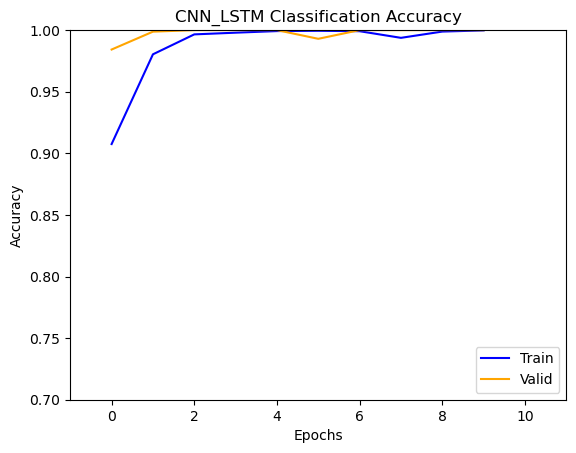

In [7]:
#summarize history on classification Accuracy
import matplotlib.pyplot as plt
x = np.linspace(0,9,10,dtype = np.int32)

training_accuracy = np.array(history.history['accuracy'])
validation_accuracy = np.array(history.history['val_accuracy'])

plt.plot(x,training_accuracy[x],color = 'blue',label = 'Train')
plt.plot(x,validation_accuracy[x],color = 'orange',label = 'Valid')

plt.xlim(-1,11)
plt.ylim(0.70,1.0)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN_LSTM Classification Accuracy')
plt.legend(frameon = True,loc = 'lower right')

76/76 [==============================] - 2s 13ms/step


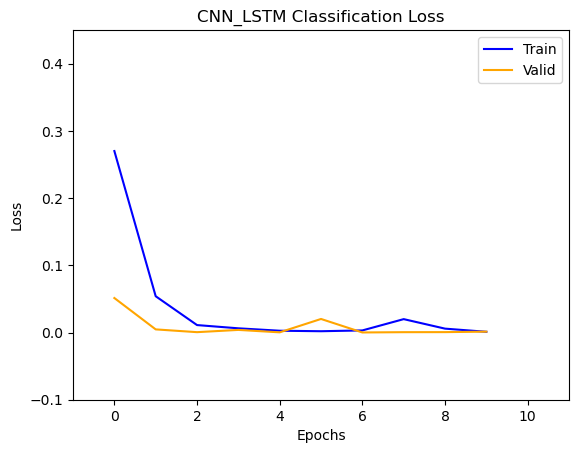

In [8]:
#summarize history on classification loss
X_test = X_test.astype('float32')
training_loss = np.array(history.history['loss'])
validation_loss = np.array(history.history['val_loss'])

plt.plot(x,training_loss[x],color = 'blue',label = 'Train')
plt.plot(x,validation_loss[x],color = 'orange',label = 'Valid')

plt.xlim(-1,11)
plt.ylim(-0.1,0.45)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN_LSTM Classification Loss')
plt.legend(frameon = True,loc = 'upper right')

predict = model.predict(X_test)
predict= np.round(predict)
predict = [int(x) for x in predict]
from sklearn.metrics import confusion_matrix

Y_test = Y_test.astype(int)
predict = np.array(predict).astype(int)

tp_ls,fp_ls,fn_ls,tn_ls = confusion_matrix(Y_test, predict).ravel()
acc_ls=(tp_ls+tn_ls)/(tp_ls+fp_ls+fn_ls+tn_ls)
rec_ls=tp_ls/(tp_ls+fn_ls)
rec_lsa=tn_ls/(tn_ls+fp_ls)
pre_ls=tp_ls/(tp_ls+fp_ls)
pre_lsa=tn_ls/(tn_ls+fn_ls)
fpr_ls=fp_ls/(fp_ls+tn_ls)
fnr_ls=fn_ls/(fn_ls+tp_ls)
f_ls=2*pre_ls*rec_ls/(pre_ls+rec_ls)
f_lsa=2*pre_lsa*rec_lsa/(pre_lsa+rec_lsa)

In [12]:
import csv
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scapy.all import ARP, sniff


In [13]:
# Initialize CSV file
def init_arpcsv():
    fname = "arp_stats.csv"
    writ = csv.writer(open(fname, 'w', buffering=1), delimiter=',')
    header = ["time", "src_mac_addr(arp)", "dst_mac_addr(arp)", "src_mac_addr(eth)", "dst_mac_addr(eth)", "src_ip(arp)", "dst_ip(arp)", "op_code(arp)"]
    writ.writerow(header)

In [14]:
# Update CSV file
def update_arpcsv(packet):
    fname = "arp_stats.csv"
    writ = csv.writer(open(fname, 'a', buffering=1), delimiter=',')
    ti = time.strftime("%m/%d/%Y, %H:%M:%S", time.localtime())
    row = [ti, packet[ARP].hwsrc, packet[ARP].hwdst, packet.src, packet.dst, packet[ARP].psrc, packet[ARP].pdst, packet[ARP].op]
    writ.writerow(row)

In [15]:
# Packet handler
def arp_display(packet):
    if packet.haslayer(ARP):  # who-has (request)
        update_arpcsv(packet)

        # Preprocess packet data for the model
        data = np.array(packet[ARP])
        data = pad_sequences(data, maxlen=65)
        data = data.reshape(1, 65, 1)

In [ ]:
# Load your model
model = load_model("best_weights_CNN_LSTM.hdf5")

# Define a list to store packet data
packet_data = []

# Define a dictionary to map MAC addresses to numerical representations
mac_to_num = {}

# Function to preprocess MAC addresses
def preprocess_mac(mac):
    if mac not in mac_to_num:
        mac_to_num[mac] = len(mac_to_num)
    return mac_to_num[mac]

# Function to process each packet
def arp_display(packet):
    global packet_data

    data = packet[ARP].hwsrc
    packet_data.append(preprocess_mac(data))

    return packet
    
# Function to process each packet
def arp_display(packet):
    global packet_data

    data = packet[ARP].hwsrc
    packet_data.append(preprocess_mac(data))

    from sklearn.preprocessing import LabelEncoder
    
    # Encode the string data
    encoded_data = label_encoder.fit_transform(packet_data)

    # Preprocess packet data for the model
    processed_data = pad_sequences(np.array([encoded_data]), maxlen=65, dtype=float)

    # Reshape the processed_data array if needed
    processed_data = processed_data.reshape(1, 65, 1)  # Adjust the shape as per your model's requirements

    # Predict using the model
    prediction = model.predict(processed_data)

    if prediction > 0.5:  # Set a threshold for detection
        print("Poisoning detected!")
        print("Request: " + packet[ARP].psrc + " is asking about " + packet[ARP].pdst)
        print("Response: " + packet[ARP].hwsrc + " has address " + packet[ARP].psrc)

# Start sniffing
sniff(prn=arp_display, filter="arp", store=0)